##  Study of the T-seed selection using BDT- XGBoost classifier
-----------------------------
This script contains all of my study based on **BDT - [XGBoost](https://github.com/dmlc/xgboost)**.  
I want to compare results of sklearn's GradientBoostedClassifier and XGBoost.  
[Rumour](https://github.com/dmlc/xgboost/blob/master/demo/README.md) has it that XGBoost is better than sklern's Gradient Boosted Classifier. We will see.  
The study contains similar steps as Baseline-BDT. 

Study roadmap 
--------------
1. Train  the first version of XGBoost with default parameters and without any features engineering. Just to know baseline score. 
2. Add basic features transformation eg. pseudorapidity and absolute values. 
3. Tune hiperparameters. As a first take care of number of trees and learning rate
4. Try to balance training dataset. 
4. Add linear combination and features's ratios  
   4.1 See at the learning curve. If needed perform step 3 for the new dataset.  
5. Speedup the algorithm using idea of [bonsai Decision Trees](http://arxiv.org/pdf/1210.6861v1.pdf)  
   I will use implementation of bBDT from [hep_ml](https://github.com/arogozhnikov/hep_ml/blob/master/hep_ml/speedup.py). See detailed study description below. 
6. Implement bBDT in C++  

The result to beat is 0.8131906
-----------


In [2]:
print ("kernel is alive!")

kernel is alive!


In [3]:
import root_numpy
import root_pandas
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import ROOT
%matplotlib inline

import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")
import seaborn as sns

#sklearn imports 
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import cross_validation
from sklearn.metrics import roc_curve, auc
from sklearn import grid_search
from sklearn.metrics import classification_report

from sklearn.externals import joblib

import xgboost as xgb

from hep_ml.speedup import LookupClassifier

Welcome to ROOTaaS 6.06/02


As a very first step I need to grab training data form the NTpule. 
--------------------------
To obtain this goal I will use **root_numpy**, that allows me to convert root NTuple to pandas.Dataframe

In [10]:
training_file_name = "datasets/Brunel_BdJPsiKs_MagU_30k.root"

In [11]:
root_file = ROOT.TFile(training_file_name)
root_file.cd("ToolSvc.PatDebugTTTruthTool")
tree = ROOT.gDirectory.Get("DownstreamSeedDebugTuple")
data = pd.DataFrame(root_numpy.tree2array(tree))

features = data.drop(["is_true_seed","has_MCParticle",
                      "is_downstream_reconstructible",
                      "has_MCParticle_not_electron",
                     "is_downstream_reconstructible_not_electron",
                     "seed_mva_value"] , axis=1).astype(numpy.float64)

target = data.is_downstream_reconstructible

features.head()

,seed_chi2PerDoF,seed_p,seed_pt,seed_nLHCbIDs,seed_nbIT,seed_nLayers,seed_x,seed_y,seed_tx,seed_ty
0,1.447929,1849.101146,1083.522737,27,0,12,-1418.736880,-143.095899,-0.722093,-0.038671
1,0.354945,10085.622823,1345.148537,24,0,12,-393.699553,-284.193871,-0.129122,-0.037920
2,2.906524,2441.534682,1013.888408,24,0,12,-834.004914,-270.235334,-0.456235,-0.015198
3,3.234916,2604.073941,904.097232,24,0,12,-475.119652,-230.380918,-0.369728,-0.018967
4,0.842265,2644.554049,1068.602364,23,0,12,-899.187260,-101.826800,-0.440227,-0.036610


Train xgboost classifier with default parameters
-------------
At first I need to split data into training and test subsets. 

In [12]:
trainX, testX, trainY, testY = train_test_split(features, target, random_state=42,train_size=0.5 )

In [13]:
gb = xgb.XGBClassifier(n_estimators=600, learning_rate=0.07 ,nthread=10,max_depth=6)
gb.fit(trainX,trainY)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.07, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=600, nthread=10,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [14]:
print "ROC AUC score"
roc_auc_score(testY, gb.predict_proba(testX)[:, 1])

ROC AUC score


0.93662753771821994

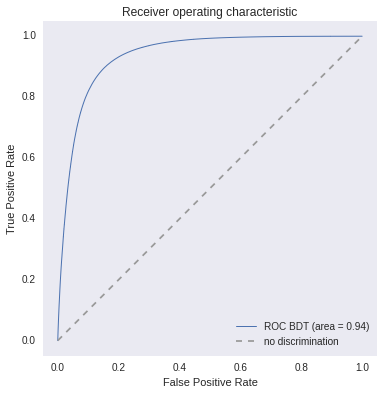

In [15]:
plt.figure(figsize=[6, 6])
fpr, tpr, thresholds = roc_curve(testY, gb.predict_proba(testX)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC BDT (area = %0.2f)'%(roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

Feature Engineering
======================
Add transformated features
-------------------
At the begining let's try some very basic feature transformation.  
I also add pseudorapidity and seed_r

In [16]:
def basic_transforamtion(data):
    #abs transformation
    out = data
    out["abs_seed_x"]=numpy.abs(data['seed_x'])
    out["abs_seed_y"]=numpy.abs(data['seed_y'])
    out["abs_seed_tx"]=numpy.abs(data['seed_tx'])
    out["abs_seed_ty"]=numpy.abs(data['seed_ty'])
    out['seed_r'] = numpy.sqrt(numpy.square(data.seed_x) +numpy.square(data.seed_y))    
    out['pseudo_rapidity'] = numpy.arctanh(data.seed_pt/data.seed_p)
    return out

In [17]:
new_data = basic_transforamtion(data)
new_features =  new_data.drop(["is_true_seed","has_MCParticle",
                    "is_downstream_reconstructible",
                    "has_MCParticle_not_electron",
                    "is_downstream_reconstructible_not_electron",
                    "seed_mva_value",
                    "seed_x",
                    "seed_y",
                    "seed_tx",
                    "seed_ty"] , axis=1).astype(numpy.float64)

new_features.head()

,seed_chi2PerDoF,seed_p,seed_pt,seed_nLHCbIDs,seed_nbIT,seed_nLayers,abs_seed_x,abs_seed_y,abs_seed_tx,abs_seed_ty,seed_r,pseudo_rapidity
0,1.447929,1849.101146,1083.522737,27,0,12,1418.736880,143.095899,0.722093,0.038671,1425.935051,0.671511
1,0.354945,10085.622823,1345.148537,24,0,12,393.699553,284.193871,0.129122,0.037920,485.556891,0.134172
2,2.906524,2441.534682,1013.888408,24,0,12,834.004914,270.235334,0.456235,0.015198,876.693408,0.441959
3,3.234916,2604.073941,904.097232,24,0,12,475.119652,230.380918,0.369728,0.018967,528.028457,0.362240
4,0.842265,2644.554049,1068.602364,23,0,12,899.187260,101.826800,0.440227,0.036610,904.934487,0.428511


In [18]:
new_trainX, new_testX, new_trainY, new_testY = train_test_split(new_features, target, random_state=42,train_size=0.5 )

In [19]:
gb2 = xgb.XGBClassifier(learning_rate=0.1, n_estimators=600, subsample=0.8, max_depth=6, nthread=10)
gb2.fit(new_trainX,new_trainY)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=600, nthread=10,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8)

In [20]:
roc_auc_score(new_testY, gb2.predict_proba(new_testX)[:, 1])

0.94187246122178814

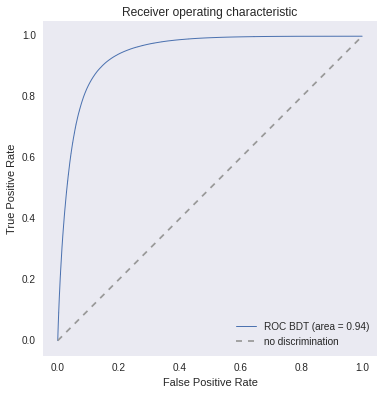

In [ ]:
plt.figure(figsize=[6, 6])
fpr, tpr, thresholds = roc_curve(new_testY, gb2.predict_proba(new_testX)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC BDT (area = %0.2f)'%(roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

Hyperparameters optimalization
----------------
Let's try to improve above classifier by serching for the best hyperparameters values. 
In the first iteration I want to find the best values of following hyperparameters:
* Number of trees. The cosidered range of n_estimators is between 50 and 250, step = 50
* learning rate in range 0.01-3 with semilogaritmic step

I use only 10% of data for grid search. Should be enough.

In [ ]:
train_gs_X, test_gs_X, train_gs_Y, test_gs_Y = train_test_split(new_features, target, random_state=42,train_size=0.1 )
gb_grid_params = {"n_estimators": [x  for x in range(49,251) if x % 50 == 0],
                   "learning_rate": [0.01, 0.03,0.1,0.3,1]}
print(gb_grid_params)

gb_gs = xgb.XGBClassifier()

clf = grid_search.GridSearchCV(gb_gs,                               
                               gb_grid_params,
                               cv=3,
                               scoring='roc_auc',
                               verbose = 3, 
                               n_jobs=8);
clf.fit(train_gs_X, train_gs_Y);


{'n_estimators': [50, 100, 150, 200, 250], 'learning_rate': [0.01, 0.03, 0.1, 0.3, 1]}
Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] n_estimators=50, learning_rate=0.01 .............................
[CV] n_estimators=50, learning_rate=0.01 .............................
[CV] n_estimators=50, learning_rate=0.01 .............................
[CV] n_estimators=100, learning_rate=0.01 ............................
[CV] n_estimators=100, learning_rate=0.01 ............................
[CV] n_estimators=100, learning_rate=0.01 ............................
[CV] n_estimators=150, learning_rate=0.01 ............................
[CV] n_estimators=150, learning_rate=0.01 ............................


In [ ]:
print("Best parameters set found on development set:")
print(clf.best_params_)
print("Grid scores on development set:")
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
        % (mean_score, scores.std() * 2, params))

In [ ]:
new_trainX, new_testX, new_trainY, new_testY = train_test_split(new_features, target, random_state=42,train_size=0.5 )
gb2 = xgb.XGBClassifier(learning_rate=0.3, n_estimators=250, max_depth=6)
gb2.fit(new_trainX,new_trainY)

In [ ]:
print "ROC AUC score - model XGBoost with learning rate 0.3 and number of trees 250"
roc_auc_score(new_testY, gb2.predict_proba(new_testX)[:, 1])

In [ ]:
plt.figure(figsize=[6, 6])
fpr, tpr, thresholds = roc_curve(new_testY, gb2.predict_proba(new_testX)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC BDT (area = %0.2f)'%(roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

Show dependency of BDT quality on the number of trees. 
----------
I plot the learning curve, number of trees vs score, of the BDT classifier.  
This plot allows me to decide weather or not decrease the number of trees. 

To obtain this values I use staged_predict_proba

In [ ]:
tree_scores = [] 
for tree_nb in range(1,249):
    proba = gb2.predict_proba(new_testX,ntree_limit=tree_nb)
    predicted = proba[:, 1]
    score =  roc_auc_score(new_testY, predicted)
    tree_scores.append(score)

In [ ]:
x = numpy.array([x  for x in range(1,249)])
plt.figure()
plt.plot(x,tree_scores)
plt.ylim(0.75, 0.82)
plt.xlabel('no of trees')
plt.ylabel('score ROC_AUC')
plt.show()

Train the new model
----------
* n_estimators 400
* learning rate 0.3

In [ ]:
train_X, test_X, train_Y, test_Y = train_test_split(new_features, target, random_state=42,train_size=0.5 )

gb3 = xgb.XGBClassifier( n_estimators=400, learning_rate=0.2, max_depth=6)
gb4.fit(train_X,train_y2)
joblib.dump(gb4, 'models/XGBoost_400_balanced.pkl') 

In [ ]:
gb3 = joblib.load('models/XGBoost_400trees.pkl')
train_X, test_X, train_Y, test_Y = train_test_split(new_features, target, random_state=42,train_size=0.5 )              

In [ ]:
print "ROC AUC score"
roc_auc_score(test_Y, gb3.predict_proba(test_X)[:, 1])

In [ ]:
plt.figure(figsize=[6, 6])
fpr, tpr, thresholds = roc_curve(test_Y, gb3.predict_proba(test_X)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC BDT (area = %0.2f)'%(roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.plot([0.95, 1], [0.95, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=[6, 6])
fpr, tpr, thresholds = roc_curve(test_Y, gb3.predict_proba(test_X)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC BDT (area = %0.2f)'%(roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.plot([0.95, 1], [0.95, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.xlim([0.5, 1])
plt.ylim([0.95, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Zoomed receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [ ]:
tree_scores = [] 
for tree_nb in range(1,399):
    proba = gb3.predict_proba(test_X,ntree_limit=tree_nb)
    predicted = proba[:, 1]
    score =  roc_auc_score(test_Y, predicted)
    print("".join(["tree ",str(tree_nb), " score ", str(score)]))
    tree_scores.append(score)

In [ ]:
x = numpy.array([x  for x in range(400)])
plt.figure()
plt.plot(x,tree_scores[:400])
plt.ylim(0.76, 0.825)
plt.xlabel('no of trees')
plt.ylabel('score ROC_AUC')
plt.show()